# Epoxy-resin polymer thermoset material

Run this notebook to reproduce the Deep Active Subspace (DAS) results for the epoxy resin application. Small variation in the results will occur due to the stochastic nature of the training procedure. Some KAS-GP are also displayed. These are loaded from file, and not directly computed here.

### Reference

Wouter Edeling, Maxime Vassaux, Yiming Yang, Shunzhou Wan, Serge Guillas, Peter Coveney, *Global ranking of the sensitivity of interaction potential contributions within classical molecular dynamics force fields*, (submitted), 2023.

### Install EasySurrogate

The Deep Active Subspace method is implemented in EasySurrogate. Uncomment to install.

In [1]:
#!pip install easysurrogate==0.24.1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import easysurrogate as es
from scipy import linalg, stats
import pandas as pd
import json
import os
import seaborn as sns
from tqdm import tqdm

Several subroutines specific to this article are located in `../utils/utils.py`. Import this module.

In [3]:
import sys
sys.path.insert(1, '../')
from utils.utils import plot_sensitivity, plot_errors, plot_dist, early_stopping

In [4]:
%matplotlib inline
# save figures at 300 dpi
plt.rcParams['savefig.dpi'] = 300

### Load prior ranges

The JSON file below contains all default values and boundaries used for specifying the Uniform input parameter distributions. 

In [5]:
# Load the EasyVVUQ params dict
priors = json.load(open('./epoxy.params.json', 'r'))

### Load input parameter values

Load the Monte Carlo values of the inputs.

In [6]:
# input parameters
params = pd.read_csv('./data_epoxy/epoxy_inputs.csv')
param_names = params.keys()
params = params.values

# number of samples
n_samples = params.shape[0]

# number of inputs
D = params.shape[1]

# scale inputs within [-1, 1]
p_max = np.array([priors[name]['default'] * 1.15 for name in param_names])
p_min = np.array([priors[name]['default'] * 0.85 for name in param_names])
params = (params - 0.5 * (p_min + p_max)) / (0.5 * (p_max - p_min))

### Load output samples

Load the corresponding Monte Carlo outputs. We used `E11`, the 11 component of the elasticity tensor (equal to the Young's modulus `E` in this isotropic case), and the Poisson ratio.

In [7]:
# Output QoI
QoI = 'E11'   # E11=E22_E33=E due to isotropy of the material
# QoI = 'poisson'

output = pd.read_csv('./data_epoxy/epoxy_%s_output.csv' % (QoI,)).values

### Average over the random seeds (or not)

Each parameter value was replicated several times, changing only the random seed of the initial condition.

In [8]:
average_over_replicas = False

if not average_over_replicas:
    samples = output[:, 0].reshape([-1, 1])
else:
    samples = np.mean(output, axis=1, keepdims=True)

### Select $d$

This is the dimension of the active subspace.

In [9]:
d = 1

###  Set hyperparameters

In [10]:
# number of neurons per hidden layer 
n_hidden_neurons = 10
# number of hidden layer + output layer
n_layers = 4
# activation function
activation = 'tanh'

# mini batch size
batch_size = 32
# max number of epochs
n_epochs_max = 100
# number of mini-batch iterations per epoch
n_iter = int(n_samples / batch_size)

# early stopping parameters
min_delta = 0.001
patience = 3

### Train / test split

In [11]:
# test fraction
test_frac = 0.1
# indices of the test set
test_idx = int((1 - test_frac) * n_samples)
# training set
params_train = params[0:test_idx, :]
samples_train = samples[0:test_idx, :]
# test set
params_test = params[test_idx:, :]
samples_test = samples[test_idx:, :]

### Select how many replica neural networks to train

To compute confidence intervals on the results (due to the stochastic nature of the training), we train `n_rep` replica networks instead of relying a single network

In [12]:
n_rep = 20

### Train a deep active subspace network



In [13]:
# results dict
results_das = {}
# eigenvalues of gradient matrix C per epoch
results_das['eigvals'] = np.zeros([n_rep, D])
# global gradient-based sensitivity indices per epoch
results_das['V_i'] = np.zeros([n_rep, D])
# relative training and test error per epoch
results_das['errors'] = []
results_das['epoch_stop'] = np.zeros(n_rep, dtype=int)
results_das['projection_matrix'] = []
results_das['surrogate'] = []
results_das['C_das'] = []

In [14]:
def train_das(failure_criterion = 1.0):
    """
    Train DAS networks using early stopping.
    
    failure_criterion : float
        Most replica networks will converge, a small number might not. 
        failure_critertion is the value of the relative test error
        used to determine if a network did not converge. If exceeded
        the network will be discarded. Default value is 1.0 (100% test error).

    """
    min_test_error = 1.0

    # repeat analysis n_rep times to generate error bars on results
    for rep in range(n_rep):

        # train remaining epochs through early stopping
        final_test_error = 2.0
        while final_test_error > failure_criterion:
        
            # create new DAS network and train for 1 epoch
            das_surrogate = es.methods.DAS_Surrogate()
            das_surrogate.train(params_train, samples_train, d, 
                                n_iter=n_iter,
                                n_layers=n_layers,
                                n_neurons=n_hidden_neurons, 
                                activation=activation, 
                                batch_size=batch_size,
                                standardize_X=False, standardize_y=True)

            # train remaining epochs through early stopping
            errors, epoch = early_stopping(das_surrogate, n_iter,
                                           params_train, samples_train, 
                                           params_test, samples_test)
            final_test_error = errors[epoch, 1]

        results_das['errors'].append(errors)
        results_das['epoch_stop'][rep] = epoch

        ### Compute active subspace of the DAS network

        # the gradient matrix computed of the DAS network, computed using the classical AS method
        C_das = 0.0

        # Number of Monte Carlo samples
        n_mc = params.shape[0]    

        # Compute C_das, the gradient matrix of the DAS network
        das_samples = np.zeros(n_mc)
        for i, param in enumerate(params):
            # compute the derivative of f at the input layer (needed for C_das)
            df_dx = das_surrogate.derivative(param, norm=False)
            # update C_das
            C_das += np.dot(df_dx, df_dx.T) / n_mc

        results_das['C_das'].append(C_das)
            
        # solve eigenvalue problem for C_das
        eigvals_C_das, eigvecs_C_das = linalg.eigh(C_das)

        # Sort the eigensolutions in the descending order of eigenvalues
        order = eigvals_C_das.argsort()[::-1]
        eigvals_C_das = eigvals_C_das[order]
        eigvecs_C_das = eigvecs_C_das[:, order]

        # store eigenvalues of this iteration
        results_das['eigvals'][rep] = eigvals_C_das

        # the DAS weight matrix of the first hidden layer
#         W_1 = das_surrogate.neural_net.layers[1].W
#         results_das['projection_matrix'].append(W_1)
        # The dominant eigenvector(s) from the C_das matrix (alternative to W_1)
        results_das['projection_matrix'].append(eigvecs_C_das[:, 0:d])

        # perform sensitivity analysis using combined training and test data 
        das_analysis = es.analysis.DAS_analysis(das_surrogate)
        idx, V_i = das_analysis.sensitivity_measures(params, norm=False)
        results_das['V_i'][rep] = V_i.flatten() #* das_surrogate.neural_net.y_std ** 2

        # store surrogate
        results_das['surrogate'].append(das_surrogate)


Train `n_rep` DAS surrogate. A converged DAS network will have a test error well below 40%, set `failure_criterion=0.4`.

In [15]:
train_das(failure_criterion=0.4)

Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  450/450 samples to train the ML model
Neural net parameters
Number of layers = 4
Number of features = 103
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'tanh', 'linear']
This neural network has 244 weights.
Training Deep Active Subspace Neural Network...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 560.43it/s]


 loss = 0.8786
Relative training error = 43.3180 %
Relative test error = 35.6936 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 601.04it/s]


 loss = 0.9262
Relative training error = 39.1260 %
Relative test error = 36.3819 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 600.93it/s]

 loss = 0.9613


Relative training error = 34.9197 %
Relative test error = 37.7506 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 512.04it/s]


 loss = 0.9917
Relative training error = 30.5806 %
Relative test error = 34.2211 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4398


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 427.85it/s]


Relative training error = 26.9485 %
Relative test error = 28.2003 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6176


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 617.79it/s]


Relative training error = 23.3118 %
Relative test error = 27.2270 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 595.69it/s]


 loss = 0.1660
Relative training error = 20.8158 %
Relative test error = 25.3427 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 709.90it/s]

 loss = 0.2833


Relative training error = 18.7567 %
Relative test error = 24.7484 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 576.76it/s]

 loss = 0.0931


Relative training error = 17.2495 %
Relative test error = 24.6459 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 666.02it/s]


 loss = 0.2521
Relative training error = 15.7806 %
Relative test error = 22.2233 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 627.98it/s]

 loss = 0.1132


Relative training error = 14.8053 %
Relative test error = 20.2608 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 727.73it/s]

 loss = 0.2172


Relative training error = 13.4491 %
Relative test error = 17.6676 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 607.41it/s]


 loss = 0.0682
Relative training error = 12.7965 %
Relative test error = 17.2738 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 682.75it/s]

 loss = 0.0517


Relative training error = 12.3074 %
Relative test error = 15.3951 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 722.28it/s]

 loss = 0.1161


Relative training error = 11.6093 %
Relative test error = 15.4011 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 681.06it/s]

 loss = 0.1423


Relative training error = 11.1066 %
Relative test error = 14.9179 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 653.41it/s]


 loss = 0.0424
Relative training error = 10.8120 %
Relative test error = 14.4351 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.09it/s]

 loss = 0.0746


Relative training error = 10.5191 %
Relative test error = 14.0267 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 656.30it/s]

 loss = 0.0291


Relative training error = 10.3184 %
Relative test error = 13.6848 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 720.18it/s]

 loss = 0.0425


Relative training error = 10.1904 %
Relative test error = 13.7742 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 637.70it/s]

 loss = 0.0433


Relative training error = 10.0633 %
Relative test error = 13.8926 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 752.45it/s]


 loss = 0.1585
Relative training error = 9.8748 %
Relative test error = 14.5886 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 648.58it/s]

 loss = 0.0337


Relative training error = 9.5282 %
Relative test error = 13.8951 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 552.27it/s]

 loss = 1.3511


Relative training error = 44.7958 %
Relative test error = 41.6393 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 628.50it/s]


 loss = 0.7019
Relative training error = 41.8710 %
Relative test error = 40.2667 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 723.15it/s]

 loss = 1.6061


Relative training error = 38.0615 %
Relative test error = 38.6019 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 599.45it/s]

 loss = 0.5861


Relative training error = 33.9664 %
Relative test error = 37.2624 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 715.08it/s]


 loss = 0.2859
Relative training error = 31.1132 %
Relative test error = 36.2059 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 681.84it/s]

 loss = 0.2904


Relative training error = 28.7156 %
Relative test error = 31.5233 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 636.59it/s]

 loss = 0.2965


Relative training error = 25.9318 %
Relative test error = 31.4520 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 665.85it/s]


 loss = 0.5624
Relative training error = 23.4510 %
Relative test error = 28.7997 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 660.62it/s]

 loss = 0.1512


Relative training error = 21.3135 %
Relative test error = 28.4670 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.0394


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 564.66it/s]


Relative training error = 19.8269 %
Relative test error = 25.5309 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 648.73it/s]


 loss = 0.5676
Relative training error = 18.3959 %
Relative test error = 23.7145 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 663.20it/s]

 loss = 0.0519


Relative training error = 17.4739 %
Relative test error = 21.9698 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 731.14it/s]

 loss = 0.1164


Relative training error = 16.6396 %
Relative test error = 21.4476 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 633.93it/s]


 loss = 0.0543
Relative training error = 16.1949 %
Relative test error = 19.1067 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 697.59it/s]

 loss = 0.2592


Relative training error = 15.4178 %
Relative test error = 19.3033 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 636.02it/s]


 loss = 0.1601
Relative training error = 14.8120 %
Relative test error = 19.2669 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 738.13it/s]


 loss = 0.1589
Relative training error = 14.2129 %
Relative test error = 17.9496 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 724.13it/s]

 loss = 0.0167


Relative training error = 13.7597 %
Relative test error = 17.5783 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 707.20it/s]


 loss = 0.0791
Relative training error = 13.1329 %
Relative test error = 17.0551 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 638.29it/s]

 loss = 0.1072


Relative training error = 12.6383 %
Relative test error = 16.4354 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 697.66it/s]

 loss = 0.1483


Relative training error = 12.2985 %
Relative test error = 15.9704 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 680.44it/s]

 loss = 0.1401


Relative training error = 12.0394 %
Relative test error = 15.8969 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 746.60it/s]

 loss = 0.0358
Relative training error = 11.8040 %


Relative test error = 15.5870 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 721.75it/s]

 loss = 0.0604
Relative training error = 11.7482 %


Relative test error = 15.8550 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 712.29it/s]

 loss = 0.0324


Relative training error = 11.5495 %
Relative test error = 16.2992 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 673.92it/s]

 loss = 0.0402
Relative training error = 11.2031 %


Relative test error = 15.7529 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 684.17it/s]

 loss = 0.0275
Relative training error = 11.0479 %


Relative test error = 15.3286 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 609.09it/s]

 loss = 0.0265
Relative training error = 10.8809 %
Relative test error = 15.2887 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 607.31it/s]

 loss = 0.0821


Relative training error = 10.7222 %
Relative test error = 15.5431 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 608.36it/s]

 loss = 0.0210


Relative training error = 10.6457 %
Relative test error = 15.2059 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 718.28it/s]

 loss = 0.0361


Relative training error = 10.4334 %
Relative test error = 14.8254 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 674.44it/s]

 loss = 0.0557


Relative training error = 10.3526 %
Relative test error = 14.5433 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 738.17it/s]

 loss = 0.0403


Relative training error = 10.1492 %
Relative test error = 14.4030 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 559.98it/s]

 loss = 0.0314


Relative training error = 10.1603 %
Relative test error = 13.9713 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 709.07it/s]

 loss = 0.0412


Relative training error = 9.9869 %
Relative test error = 14.6837 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 656.53it/s]

 loss = 0.0217


Relative training error = 9.7699 %
Relative test error = 14.8012 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 613.38it/s]

 loss = 0.0188


Relative training error = 9.6471 %
Relative test error = 15.3449 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 640.91it/s]

 loss = 0.0475
Relative training error = 9.4883 %
Relative test error = 15.6841 %


Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.10893024e-02
  1.38355662e-02  1.55181759e-02  7.77773490e-03  4.02404911e

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 576.86it/s]


 loss = 2.2414
Relative training error = 44.6934 %
Relative test error = 34.3487 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 603.80it/s]

 loss = 0.9625


Relative training error = 43.7307 %
Relative test error = 35.3587 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.3364


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 345.57it/s]


Relative training error = 41.8592 %
Relative test error = 34.9641 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 627.74it/s]

 loss = 0.7068


Relative training error = 39.8499 %
Relative test error = 33.7596 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 676.40it/s]


 loss = 1.1151
Relative training error = 37.0602 %
Relative test error = 35.4258 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 633.44it/s]

 loss = 0.3725


Relative training error = 34.2261 %
Relative test error = 34.7862 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.33it/s]

 loss = 1.1011


Relative training error = 31.9462 %
Relative test error = 33.0866 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.11it/s]


 loss = 0.2028
Relative training error = 29.9688 %
Relative test error = 31.8059 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3575


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 458.44it/s]


Relative training error = 27.9919 %
Relative test error = 31.3574 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 451.92it/s]


 loss = 0.3154
Relative training error = 26.0946 %
Relative test error = 31.0959 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 704.11it/s]


 loss = 0.2707
Relative training error = 24.2753 %
Relative test error = 29.8901 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6087


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 716.73it/s]


Relative training error = 22.6170 %
Relative test error = 27.9187 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 708.31it/s]


 loss = 0.8228
Relative training error = 20.9627 %
Relative test error = 25.4429 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 747.45it/s]


 loss = 0.0881
Relative training error = 19.7110 %
Relative test error = 23.3984 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 701.66it/s]


 loss = 0.1047
Relative training error = 18.9300 %
Relative test error = 21.9664 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 691.95it/s]

 loss = 0.2117


Relative training error = 17.5950 %
Relative test error = 21.4248 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 668.54it/s]

 loss = 0.3239


Relative training error = 16.4514 %
Relative test error = 20.5518 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 704.24it/s]


 loss = 0.0426
Relative training error = 15.4741 %
Relative test error = 20.0636 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 682.32it/s]

 loss = 0.3218


Relative training error = 14.8384 %
Relative test error = 19.0048 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 722.38it/s]

 loss = 0.0425


Relative training error = 14.2820 %
Relative test error = 18.2917 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 630.89it/s]


 loss = 0.0385
Relative training error = 14.0597 %
Relative test error = 17.6014 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 602.74it/s]

 loss = 0.0726


Relative training error = 13.5733 %
Relative test error = 17.5621 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 633.10it/s]


 loss = 0.1224
Relative training error = 13.1003 %
Relative test error = 17.4933 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0383


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 683.27it/s]


Relative training error = 12.6569 %
Relative test error = 17.0332 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0351


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 677.53it/s]


Relative training error = 12.3818 %
Relative test error = 16.6654 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 655.81it/s]


 loss = 0.0346
Relative training error = 12.1352 %
Relative test error = 15.8680 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 565.74it/s]

 loss = 0.0368


Relative training error = 12.0106 %
Relative test error = 15.1100 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 625.62it/s]

 loss = 0.1054


Relative training error = 11.8780 %
Relative test error = 14.5673 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 533.34it/s]

 loss = 0.1203


Relative training error = 11.6108 %
Relative test error = 14.8794 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0912


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 669.25it/s]


Relative training error = 11.3898 %
Relative test error = 14.6273 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0187


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 645.11it/s]


Relative training error = 11.1880 %
Relative test error = 14.9844 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 721.63it/s]

 loss = 0.0494


Relative training error = 10.9922 %
Relative test error = 14.9679 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 743.19it/s]

 loss = 0.0709


Relative training error = 10.7920 %
Relative test error = 14.7843 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 730.77it/s]

 loss = 0.0889
Relative training error = 10.6644 %
Relative test error = 14.6355 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 731.54it/s]

 loss = 0.0344
Relative training error = 10.5682 %
Relative test error = 14.4321 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 675.32it/s]

 loss = 0.0158


Relative training error = 10.4113 %
Relative test error = 15.2695 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.13it/s]


 loss = 0.0222
Relative training error = 10.2178 %
Relative test error = 15.1343 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.90it/s]


 loss = 0.0192
Relative training error = 10.0639 %
Relative test error = 15.0545 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 754.51it/s]

 loss = 0.0449
Relative training error = 9.9073 %


Relative test error = 15.3907 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 555.80it/s]

 loss = 0.0973


Relative training error = 9.7834 %
Relative test error = 14.9332 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 721.21it/s]

 loss = 0.0560


Relative training error = 9.7941 %
Relative test error = 14.8762 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 749.13it/s]

 loss = 0.0323


Relative training error = 9.5517 %
Relative test error = 14.4342 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 641.32it/s]

 loss = 0.0286


Relative training error = 9.4669 %
Relative test error = 15.1664 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 693.40it/s]

 loss = 0.0371


Relative training error = 9.2900 %
Relative test error = 14.3032 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 697.19it/s]

 loss = 0.1093
Relative training error = 9.2595 %


Relative test error = 13.5739 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 696.73it/s]

 loss = 0.1064
Relative training error = 9.1708 %
Relative test error = 13.7411 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 667.89it/s]

 loss = 0.0270


Relative training error = 9.0785 %
Relative test error = 13.8597 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 704.21it/s]

 loss = 0.0345


Relative training error = 9.0305 %
Relative test error = 14.2065 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 661.61it/s]


 loss = 0.0385
Relative training error = 8.9291 %
Relative test error = 13.7612 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6591


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 613.14it/s]


Relative training error = 48.3990 %
Relative test error = 48.3082 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 506.64it/s]

 loss = 0.9425


Relative training error = 42.2372 %
Relative test error = 37.6547 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 651.10it/s]

 loss = 0.4248


Relative training error = 36.5038 %
Relative test error = 39.4869 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 702.81it/s]

 loss = 0.7698


Relative training error = 31.7518 %
Relative test error = 37.7676 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 662.43it/s]

 loss = 0.3913


Relative training error = 28.2624 %
Relative test error = 33.8441 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 707.68it/s]


 loss = 0.2284
Relative training error = 25.0649 %
Relative test error = 31.6894 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 645.32it/s]

 loss = 0.3068


Relative training error = 22.2537 %
Relative test error = 28.7857 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 708.23it/s]

 loss = 0.2191


Relative training error = 19.9143 %
Relative test error = 26.7558 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 532.25it/s]

 loss = 0.3946


Relative training error = 18.2864 %
Relative test error = 24.6557 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 697.23it/s]

 loss = 0.0858


Relative training error = 16.7651 %
Relative test error = 23.9141 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 535.22it/s]

 loss = 0.0919


Relative training error = 15.4711 %
Relative test error = 23.7302 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 538.94it/s]

 loss = 0.0540


Relative training error = 14.2859 %
Relative test error = 22.0886 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0754


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 629.89it/s]


Relative training error = 13.3904 %
Relative test error = 20.0319 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0595


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 675.12it/s]


Relative training error = 12.7146 %
Relative test error = 19.3966 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0370


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 688.34it/s]


Relative training error = 12.1423 %
Relative test error = 17.8458 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0439


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 512.64it/s]


Relative training error = 11.6130 %
Relative test error = 16.9378 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0649


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 667.67it/s]


Relative training error = 11.2856 %
Relative test error = 16.4710 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.73it/s]

 loss = 0.0940


Relative training error = 10.8822 %
Relative test error = 16.2923 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 614.91it/s]

 loss = 0.1217


Relative training error = 10.5081 %
Relative test error = 15.9826 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 655.01it/s]

 loss = 0.0346


Relative training error = 10.2206 %
Relative test error = 15.5630 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 583.08it/s]

 loss = 0.0395


Relative training error = 9.9663 %
Relative test error = 14.7541 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 731.23it/s]


 loss = 0.0354
Relative training error = 9.7323 %
Relative test error = 14.4248 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 667.03it/s]


 loss = 0.0303
Relative training error = 9.5987 %
Relative test error = 14.6560 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 759.97it/s]

 loss = 0.1395


Relative training error = 9.3652 %
Relative test error = 13.4424 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 676.65it/s]

 loss = 0.0261


Relative training error = 9.2602 %
Relative test error = 13.1295 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 677.89it/s]

 loss = 0.0339


Relative training error = 9.0656 %
Relative test error = 13.2674 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 501.89it/s]


Relative training error = 8.9475 %
Relative test error = 13.7483 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 619.04it/s]

 loss = 0.0318


Relative training error = 8.8783 %
Relative test error = 14.0884 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 647.22it/s]

 loss = 0.0244


Relative training error = 8.6417 %
Relative test error = 13.9572 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 587.39it/s]

 loss = 1.1932


Relative training error = 44.8327 %
Relative test error = 38.9022 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 655.95it/s]

 loss = 0.6559


Relative training error = 42.5341 %
Relative test error = 35.4824 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 667.37it/s]

 loss = 0.9681


Relative training error = 37.6110 %
Relative test error = 35.5782 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 728.15it/s]

 loss = 0.6084


Relative training error = 32.0285 %
Relative test error = 32.5734 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.13it/s]


 loss = 0.3118
Relative training error = 27.5809 %
Relative test error = 32.1579 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 735.80it/s]

 loss = 0.3128


Relative training error = 24.0560 %
Relative test error = 28.0058 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.25it/s]

 loss = 0.4193


Relative training error = 20.8331 %
Relative test error = 27.6037 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 760.27it/s]


 loss = 0.2420
Relative training error = 18.2613 %
Relative test error = 25.0588 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 690.00it/s]

 loss = 0.3262


Relative training error = 16.5128 %
Relative test error = 21.3375 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 725.47it/s]

 loss = 0.0835


Relative training error = 15.1742 %
Relative test error = 19.0998 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 651.71it/s]

 loss = 0.0718


Relative training error = 14.0076 %
Relative test error = 18.1033 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 737.00it/s]

 loss = 0.0371


Relative training error = 13.4040 %
Relative test error = 16.9339 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 669.79it/s]

 loss = 0.0472


Relative training error = 12.8059 %
Relative test error = 15.5274 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 706.79it/s]

 loss = 0.3751
Relative training error = 12.0380 %


Relative test error = 15.2071 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.10it/s]

 loss = 0.0380


Relative training error = 11.4851 %
Relative test error = 14.4886 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 746.11it/s]

 loss = 0.0317


Relative training error = 11.0731 %
Relative test error = 14.5170 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 621.22it/s]

 loss = 0.0274


Relative training error = 10.8416 %
Relative test error = 14.1124 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 565.74it/s]

 loss = 0.0368


Relative training error = 10.5366 %
Relative test error = 13.9066 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 649.46it/s]

 loss = 0.0403


Relative training error = 10.3513 %
Relative test error = 14.1058 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 742.77it/s]

 loss = 0.0327


Relative training error = 10.1639 %
Relative test error = 14.4125 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 592.44it/s]

 loss = 0.0727


Relative training error = 10.0469 %
Relative test error = 14.0552 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 636.01it/s]


 loss = 0.0408
Relative training error = 9.8829 %
Relative test error = 13.7793 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 620.27it/s]

 loss = 0.0458


Relative training error = 9.6716 %
Relative test error = 13.8680 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 619.81it/s]

 loss = 0.0733


Relative training error = 9.4328 %
Relative test error = 14.4076 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 602.30it/s]


 loss = 0.0214
Relative training error = 9.2630 %
Relative test error = 14.3019 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 709.46it/s]

 loss = 0.0170


Relative training error = 9.2070 %
Relative test error = 14.1439 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 626.53it/s]

 loss = 0.0914


Relative training error = 9.0013 %
Relative test error = 14.4554 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 652.04it/s]

 loss = 0.0551


Relative training error = 8.8923 %
Relative test error = 13.8721 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 649.21it/s]

 loss = 0.0201


Relative training error = 8.7018 %
Relative test error = 13.6034 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 578.88it/s]

 loss = 0.0227


Relative training error = 8.5832 %
Relative test error = 14.2320 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 436.46it/s]

 loss = 0.0269


Relative training error = 8.6521 %
Relative test error = 13.5765 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 729.52it/s]

 loss = 0.0365
Relative training error = 8.5981 %
Relative test error = 13.3997 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.50it/s]


 loss = 0.0238
Relative training error = 8.5238 %
Relative test error = 13.7795 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 717.83it/s]

 loss = 0.0202


Relative training error = 8.4868 %
Relative test error = 13.4413 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 638.72it/s]

 loss = 0.0217
Relative training error = 8.5075 %
Relative test error = 14.4424 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 625.40it/s]


 loss = 0.0194
Relative training error = 8.3763 %
Relative test error = 14.2788 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0479


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 679.29it/s]


Relative training error = 8.2685 %
Relative test error = 14.8888 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 315.74it/s]


 loss = 0.0399
Relative training error = 8.3289 %
Relative test error = 14.8000 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 573.67it/s]


 loss = 0.0420
Relative training error = 8.2897 %
Relative test error = 14.3919 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 681.85it/s]


 loss = 0.0289
Relative training error = 8.1801 %
Relative test error = 14.5532 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 634.83it/s]

 loss = 0.0336


Relative training error = 8.1055 %
Relative test error = 14.1263 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 703.51it/s]

 loss = 0.0269


Relative training error = 8.0879 %
Relative test error = 14.4580 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 652.30it/s]


 loss = 0.0213
Relative training error = 8.0190 %
Relative test error = 14.5496 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 694.84it/s]

 loss = 0.0218


Relative training error = 7.9730 %
Relative test error = 14.0945 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 525.48it/s]

 loss = 0.0424


Relative training error = 8.0565 %
Relative test error = 14.0433 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 305.30it/s]


Relative training error = 8.0378 %
Relative test error = 13.7623 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 436.34it/s]

 loss = 0.0330


Relative training error = 7.9675 %
Relative test error = 14.1264 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 734.16it/s]


 loss = 0.0339
Relative training error = 7.8883 %
Relative test error = 14.1767 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 705.37it/s]

 loss = 0.0563


Relative training error = 7.8830 %
Relative test error = 13.8586 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 670.62it/s]

 loss = 0.0164


Relative training error = 8.0005 %
Relative test error = 14.0572 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 632.91it/s]


 loss = 0.0359
Relative training error = 8.0394 %
Relative test error = 14.0068 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 675.43it/s]

 loss = 0.0295


Relative training error = 7.9057 %
Relative test error = 14.0612 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 696.71it/s]

 loss = 0.0282


Relative training error = 7.8132 %
Relative test error = 13.6150 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 620.74it/s]

 loss = 1.4493


Relative training error = 46.4700 %
Relative test error = 35.0383 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 579.65it/s]

 loss = 0.8059


Relative training error = 45.0038 %
Relative test error = 36.1368 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 629.67it/s]

 loss = 1.6486


Relative training error = 44.2269 %
Relative test error = 36.4129 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 743.68it/s]

 loss = 0.5846


Relative training error = 42.9105 %
Relative test error = 35.1655 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 631.64it/s]

 loss = 0.4522


Relative training error = 41.0742 %
Relative test error = 34.2234 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.03it/s]

 loss = 0.6551


Relative training error = 38.7163 %
Relative test error = 33.2043 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 681.59it/s]

 loss = 0.5710


Relative training error = 34.3479 %
Relative test error = 33.3315 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 738.00it/s]

 loss = 0.3222


Relative training error = 29.5474 %
Relative test error = 30.9052 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 675.88it/s]

 loss = 0.2417


Relative training error = 25.7331 %
Relative test error = 28.8600 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 675.89it/s]

 loss = 0.2152


Relative training error = 22.8054 %
Relative test error = 28.3500 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 668.46it/s]

 loss = 0.1436


Relative training error = 20.5605 %
Relative test error = 28.3581 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 720.98it/s]


 loss = 0.1111
Relative training error = 18.7096 %
Relative test error = 25.9681 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 701.96it/s]

 loss = 0.1259


Relative training error = 17.2396 %
Relative test error = 24.5114 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.45it/s]

 loss = 0.1406


Relative training error = 15.9536 %
Relative test error = 22.5084 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 657.48it/s]


 loss = 0.1704
Relative training error = 14.7932 %
Relative test error = 22.4315 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 641.76it/s]

 loss = 0.2111


Relative training error = 13.8420 %
Relative test error = 22.2096 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 648.28it/s]

 loss = 0.0608


Relative training error = 13.1549 %
Relative test error = 21.6841 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 724.24it/s]

 loss = 0.0624


Relative training error = 12.6334 %
Relative test error = 18.9860 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 692.43it/s]

 loss = 0.0526


Relative training error = 12.0182 %
Relative test error = 18.4364 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 483.68it/s]

 loss = 0.0662


Relative training error = 11.5265 %
Relative test error = 17.3322 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0365


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 509.21it/s]


Relative training error = 11.1500 %
Relative test error = 16.7144 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0694


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 678.45it/s]


Relative training error = 10.7806 %
Relative test error = 15.8383 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0519


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 548.69it/s]


Relative training error = 10.5513 %
Relative test error = 15.3174 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0179


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 694.23it/s]


Relative training error = 10.3610 %
Relative test error = 15.8428 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0466


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 732.39it/s]


Relative training error = 10.1802 %
Relative test error = 15.1796 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 683.20it/s]

 loss = 0.0964


Relative training error = 9.8106 %
Relative test error = 15.1854 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0641


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 645.05it/s]


Relative training error = 9.6189 %
Relative test error = 15.2163 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 706.60it/s]


 loss = 0.0284
Relative training error = 9.4753 %
Relative test error = 14.4769 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 521.92it/s]

 loss = 0.0620


Relative training error = 9.3720 %
Relative test error = 13.9422 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 724.51it/s]

 loss = 0.0323


Relative training error = 9.3065 %
Relative test error = 13.8170 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 615.74it/s]


 loss = 0.0217
Relative training error = 9.2652 %
Relative test error = 13.5219 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 684.67it/s]

 loss = 0.0240


Relative training error = 8.9369 %
Relative test error = 13.4046 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 651.79it/s]

 loss = 0.1371


Relative training error = 8.8270 %
Relative test error = 13.9830 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.43it/s]

 loss = 0.0774


Relative training error = 8.7417 %
Relative test error = 13.9399 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 642.08it/s]

 loss = 0.0336


Relative training error = 8.6652 %
Relative test error = 14.0445 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 723.24it/s]

 loss = 0.0510


Relative training error = 8.6071 %
Relative test error = 13.9954 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8952


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 616.10it/s]


Relative training error = 44.9999 %
Relative test error = 36.9474 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.8502


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.66it/s]


Relative training error = 44.7875 %
Relative test error = 36.0299 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9847


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 653.83it/s]


Relative training error = 44.7793 %
Relative test error = 38.9063 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.5830


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 557.68it/s]


Relative training error = 43.4846 %
Relative test error = 36.0889 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 676.10it/s]


 loss = 0.8728
Relative training error = 41.8023 %
Relative test error = 35.7624 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 751.29it/s]

 loss = 0.6708


Relative training error = 38.7957 %
Relative test error = 33.9462 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 667.56it/s]

 loss = 1.6207
Relative training error = 34.7466 %


Relative test error = 31.4059 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 749.69it/s]


 loss = 0.2768
Relative training error = 30.4390 %
Relative test error = 28.4662 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2649


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 675.46it/s]


Relative training error = 26.7822 %
Relative test error = 25.7078 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 740.97it/s]

 loss = 0.2128
Relative training error = 23.8433 %


Relative test error = 24.8128 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 712.02it/s]


 loss = 0.1807
Relative training error = 21.7608 %
Relative test error = 22.7853 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3772


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 643.72it/s]


Relative training error = 19.9212 %
Relative test error = 21.5847 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 749.75it/s]


 loss = 0.1021
Relative training error = 18.3960 %
Relative test error = 21.4139 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 645.99it/s]


 loss = 0.2207
Relative training error = 17.2201 %
Relative test error = 20.2897 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 743.64it/s]


 loss = 0.0451
Relative training error = 16.3414 %
Relative test error = 19.4771 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 726.03it/s]

 loss = 0.0662


Relative training error = 15.0900 %
Relative test error = 18.4467 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.11it/s]


 loss = 0.3594
Relative training error = 14.3280 %
Relative test error = 17.9302 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 625.05it/s]


 loss = 0.1671
Relative training error = 13.6077 %
Relative test error = 16.3763 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 757.02it/s]

 loss = 0.0497


Relative training error = 13.0214 %
Relative test error = 15.0102 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 662.61it/s]

 loss = 0.3008


Relative training error = 12.5363 %
Relative test error = 14.9188 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 747.00it/s]


 loss = 0.1267
Relative training error = 12.1286 %
Relative test error = 15.0901 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 654.55it/s]

 loss = 0.0220


Relative training error = 11.9853 %
Relative test error = 15.0126 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 749.35it/s]

 loss = 0.0187


Relative training error = 11.8142 %
Relative test error = 14.9225 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7617


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 617.77it/s]


Relative training error = 43.5521 %
Relative test error = 35.7217 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 648.12it/s]

 loss = 0.3939


Relative training error = 39.9416 %
Relative test error = 33.1002 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 500.97it/s]

 loss = 0.5698


Relative training error = 34.5042 %
Relative test error = 32.2545 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8802


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 522.73it/s]


Relative training error = 30.1283 %
Relative test error = 30.2062 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2018


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 642.76it/s]


Relative training error = 25.6377 %
Relative test error = 29.4592 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1898


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 623.61it/s]


Relative training error = 22.6349 %
Relative test error = 29.5208 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3811


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 616.56it/s]


Relative training error = 19.9244 %
Relative test error = 28.4517 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1796


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 616.00it/s]


Relative training error = 18.0179 %
Relative test error = 27.3759 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 676.76it/s]

 loss = 0.0616


Relative training error = 16.1736 %
Relative test error = 25.1864 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.60it/s]

 loss = 0.1198


Relative training error = 14.7175 %
Relative test error = 22.4996 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 607.39it/s]

 loss = 0.2334


Relative training error = 13.8184 %
Relative test error = 20.1005 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 541.91it/s]

 loss = 0.1317


Relative training error = 12.7723 %
Relative test error = 19.3674 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 482.34it/s]

 loss = 0.0496


Relative training error = 12.0836 %
Relative test error = 18.6283 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0386


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 589.45it/s]


Relative training error = 11.5918 %
Relative test error = 17.8472 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0436


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 680.73it/s]


Relative training error = 11.1974 %
Relative test error = 17.5482 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 627.74it/s]

 loss = 0.0463


Relative training error = 10.7795 %
Relative test error = 17.1260 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 641.85it/s]


 loss = 0.1034
Relative training error = 10.4561 %
Relative test error = 16.2170 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 679.40it/s]

 loss = 0.0362


Relative training error = 10.1012 %
Relative test error = 15.7729 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 627.11it/s]

 loss = 0.0762


Relative training error = 9.8420 %
Relative test error = 15.2155 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 692.46it/s]

 loss = 0.0490


Relative training error = 9.6808 %
Relative test error = 14.9479 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 684.02it/s]

 loss = 0.0258


Relative training error = 9.5316 %
Relative test error = 15.0053 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 692.56it/s]

 loss = 0.0211


Relative training error = 9.2976 %
Relative test error = 14.5060 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 656.32it/s]

 loss = 0.0492


Relative training error = 9.0895 %
Relative test error = 13.9070 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 633.88it/s]

 loss = 0.0393


Relative training error = 8.9816 %
Relative test error = 13.6769 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 647.41it/s]

 loss = 0.0225


Relative training error = 8.8361 %
Relative test error = 13.7024 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 755.39it/s]

 loss = 0.0732


Relative training error = 8.6485 %
Relative test error = 13.9083 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 629.76it/s]

 loss = 0.0819


Relative training error = 8.5132 %
Relative test error = 13.8700 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 717.24it/s]

 loss = 0.0186


Relative training error = 8.4388 %
Relative test error = 14.0101 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 696.83it/s]

 loss = 1.1154


Relative training error = 43.8289 %
Relative test error = 35.4557 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 608.67it/s]

 loss = 1.2172


Relative training error = 38.9886 %
Relative test error = 36.2831 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 645.30it/s]

 loss = 0.6467


Relative training error = 33.8217 %
Relative test error = 32.5103 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.16it/s]

 loss = 0.4322


Relative training error = 29.6637 %
Relative test error = 29.7174 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 693.92it/s]

 loss = 0.2728


Relative training error = 26.1739 %
Relative test error = 26.2296 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 623.97it/s]

 loss = 0.2244


Relative training error = 23.0201 %
Relative test error = 23.0778 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 663.77it/s]

 loss = 0.4779


Relative training error = 20.4238 %
Relative test error = 21.3820 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.05it/s]

 loss = 0.2378


Relative training error = 18.4181 %
Relative test error = 20.8761 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 636.94it/s]

 loss = 0.1353


Relative training error = 16.8961 %
Relative test error = 20.3213 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 673.34it/s]

 loss = 0.0349
Relative training error = 15.6104 %


Relative test error = 18.8239 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 723.68it/s]

 loss = 0.2587


Relative training error = 14.5160 %
Relative test error = 18.6327 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2509


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 661.07it/s]


Relative training error = 13.6945 %
Relative test error = 17.6869 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1390


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 678.94it/s]


Relative training error = 13.0975 %
Relative test error = 16.3451 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1267


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 665.64it/s]


Relative training error = 12.5512 %
Relative test error = 16.3070 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0274


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 595.62it/s]


Relative training error = 12.1115 %
Relative test error = 16.1805 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0315


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 690.32it/s]


Relative training error = 11.8519 %
Relative test error = 15.5374 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0523


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 458.01it/s]


Relative training error = 11.6274 %
Relative test error = 15.4046 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0883


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 517.11it/s]


Relative training error = 11.3843 %
Relative test error = 15.7581 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1547


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 607.71it/s]


Relative training error = 11.1302 %
Relative test error = 14.9282 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0403


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 701.98it/s]


Relative training error = 10.8816 %
Relative test error = 14.7450 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0218


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 659.81it/s]


Relative training error = 10.7736 %
Relative test error = 14.2883 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0346


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 707.00it/s]


Relative training error = 10.7145 %
Relative test error = 14.0263 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1839


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 609.42it/s]


Relative training error = 10.3935 %
Relative test error = 15.2601 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0360


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 676.49it/s]


Relative training error = 10.3522 %
Relative test error = 15.7436 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 661.28it/s]


 loss = 0.0405
Relative training error = 10.3453 %
Relative test error = 15.0491 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 712.46it/s]

 loss = 0.0329


Relative training error = 10.0161 %
Relative test error = 14.6981 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 568.27it/s]

 loss = 0.0718


Relative training error = 9.9684 %
Relative test error = 14.7150 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 674.44it/s]

 loss = 0.0271


Relative training error = 9.9052 %
Relative test error = 15.1701 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 595.22it/s]

 loss = 0.0234


Relative training error = 9.8702 %
Relative test error = 14.8578 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 634.40it/s]

 loss = 0.0585


Relative training error = 9.5713 %
Relative test error = 14.4767 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0299


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 604.38it/s]


Relative training error = 9.4578 %
Relative test error = 14.4095 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 666.79it/s]

 loss = 0.0231


Relative training error = 9.3610 %
Relative test error = 14.5124 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 599.87it/s]

 loss = 0.0271


Relative training error = 9.3386 %
Relative test error = 14.2331 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 615.45it/s]

 loss = 0.0532


Relative training error = 9.2328 %
Relative test error = 14.4160 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 594.52it/s]


 loss = 0.0483
Relative training error = 9.1890 %
Relative test error = 14.4658 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.65it/s]

 loss = 0.0458


Relative training error = 9.1829 %
Relative test error = 14.1734 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 634.25it/s]

 loss = 0.0684


Relative training error = 9.0806 %
Relative test error = 14.3128 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 710.89it/s]


 loss = 0.0435
Relative training error = 8.9484 %
Relative test error = 14.1220 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 674.07it/s]

 loss = 0.0268


Relative training error = 8.8313 %
Relative test error = 14.1545 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 651.24it/s]

 loss = 0.0311


Relative training error = 8.8618 %
Relative test error = 14.1961 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 624.51it/s]

 loss = 0.0725


Relative training error = 8.7069 %
Relative test error = 14.5952 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 704.63it/s]

 loss = 0.0369


Relative training error = 8.7041 %
Relative test error = 13.9236 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2795


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 558.52it/s]


Relative training error = 43.2774 %
Relative test error = 31.9395 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.38it/s]

 loss = 0.5823


Relative training error = 39.0438 %
Relative test error = 31.6404 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 619.27it/s]

 loss = 0.4837


Relative training error = 32.4627 %
Relative test error = 28.7901 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 620.06it/s]

 loss = 0.3837


Relative training error = 27.4495 %
Relative test error = 25.7244 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 580.36it/s]

 loss = 0.3431


Relative training error = 23.6250 %
Relative test error = 23.3211 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 614.60it/s]

 loss = 0.2695


Relative training error = 20.5722 %
Relative test error = 22.9128 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1591


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 574.04it/s]


Relative training error = 18.1692 %
Relative test error = 21.7066 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2191


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 637.48it/s]


Relative training error = 16.8111 %
Relative test error = 19.9775 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0813


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 569.03it/s]


Relative training error = 15.7316 %
Relative test error = 18.8210 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1441


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 688.13it/s]


Relative training error = 14.5545 %
Relative test error = 18.3419 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1403


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 529.49it/s]


Relative training error = 13.6386 %
Relative test error = 17.4411 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 712.24it/s]


 loss = 0.1369
Relative training error = 12.8828 %
Relative test error = 17.0428 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 701.47it/s]

 loss = 0.0372


Relative training error = 12.3699 %
Relative test error = 16.7193 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 676.22it/s]


 loss = 0.0513
Relative training error = 11.7314 %
Relative test error = 16.6192 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 704.86it/s]

 loss = 0.2013


Relative training error = 11.3382 %
Relative test error = 16.2289 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 597.77it/s]

 loss = 0.0351


Relative training error = 10.8562 %
Relative test error = 15.1288 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 697.90it/s]


 loss = 0.0339
Relative training error = 10.5986 %
Relative test error = 15.7563 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 540.20it/s]

 loss = 0.1099


Relative training error = 10.3594 %
Relative test error = 14.8099 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.13it/s]

 loss = 0.0414


Relative training error = 10.1642 %
Relative test error = 14.1691 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 667.11it/s]

 loss = 0.0683
Relative training error = 10.0493 %


Relative test error = 13.2438 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 706.83it/s]

 loss = 0.0450


Relative training error = 9.7708 %
Relative test error = 13.0436 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 621.99it/s]

 loss = 0.0734


Relative training error = 9.6333 %
Relative test error = 13.1508 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 725.57it/s]


 loss = 0.0390
Relative training error = 9.5910 %
Relative test error = 12.9658 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 657.05it/s]

 loss = 0.0323


Relative training error = 9.6352 %
Relative test error = 13.5327 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.93it/s]

 loss = 0.0777


Relative training error = 9.1624 %
Relative test error = 13.6281 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 619.12it/s]

 loss = 0.0501


Relative training error = 9.1804 %
Relative test error = 13.9656 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.01it/s]

 loss = 0.0784


Relative training error = 8.9537 %
Relative test error = 13.6763 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 619.10it/s]

 loss = 0.7144


Relative training error = 44.8783 %
Relative test error = 35.3242 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 651.51it/s]

 loss = 0.6099


Relative training error = 40.3979 %
Relative test error = 38.0209 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 634.66it/s]

 loss = 0.7846


Relative training error = 33.3552 %
Relative test error = 39.1753 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 658.30it/s]

 loss = 0.4873


Relative training error = 28.4229 %
Relative test error = 37.2308 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 602.50it/s]

 loss = 0.5973


Relative training error = 24.6224 %
Relative test error = 34.2973 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 637.06it/s]

 loss = 0.1201


Relative training error = 21.4828 %
Relative test error = 31.4171 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 583.60it/s]

 loss = 0.1285


Relative training error = 19.0606 %
Relative test error = 27.4899 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 623.73it/s]

 loss = 0.0872


Relative training error = 17.1166 %
Relative test error = 23.8905 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0436


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 614.92it/s]


Relative training error = 15.5326 %
Relative test error = 21.8913 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 691.13it/s]

 loss = 0.2399


Relative training error = 14.3136 %
Relative test error = 19.6580 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 676.36it/s]

 loss = 0.1441


Relative training error = 13.3226 %
Relative test error = 18.3127 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 602.67it/s]

 loss = 0.2112


Relative training error = 12.5364 %
Relative test error = 18.0456 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0539


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 555.80it/s]


Relative training error = 11.6254 %
Relative test error = 16.7530 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0372


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 581.16it/s]


Relative training error = 11.0960 %
Relative test error = 15.8748 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 725.53it/s]

 loss = 0.0491


Relative training error = 10.7731 %
Relative test error = 15.0035 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 573.29it/s]

 loss = 0.0828


Relative training error = 10.4665 %
Relative test error = 14.7343 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 734.23it/s]

 loss = 0.0807


Relative training error = 10.1304 %
Relative test error = 14.8382 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 568.02it/s]

 loss = 0.0310


Relative training error = 9.8975 %
Relative test error = 15.0789 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0822


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 512.54it/s]


Relative training error = 9.7017 %
Relative test error = 14.3017 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0275


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 654.57it/s]


Relative training error = 9.4799 %
Relative test error = 14.6730 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0522


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 438.67it/s]


Relative training error = 9.5990 %
Relative test error = 14.4514 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0340


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 535.68it/s]


Relative training error = 9.3096 %
Relative test error = 14.1333 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0318


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 654.20it/s]


Relative training error = 9.1525 %
Relative test error = 14.2472 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0265


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 610.41it/s]


Relative training error = 9.0588 %
Relative test error = 14.2743 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 623.44it/s]

 loss = 0.0206


Relative training error = 9.0256 %
Relative test error = 14.2436 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 710.74it/s]

 loss = 0.0280


Relative training error = 8.8994 %
Relative test error = 14.6689 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 523.85it/s]

 loss = 1.4310


Relative training error = 45.2118 %
Relative test error = 37.7494 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 526.67it/s]

 loss = 0.6252


Relative training error = 44.4274 %
Relative test error = 35.4572 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.3024


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 536.70it/s]


Relative training error = 41.7030 %
Relative test error = 36.0835 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5213


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 565.78it/s]


Relative training error = 36.5860 %
Relative test error = 33.3322 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2118


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 576.97it/s]


Relative training error = 31.3490 %
Relative test error = 31.2640 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 644.13it/s]

 loss = 0.4640


Relative training error = 27.1324 %
Relative test error = 30.2278 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2490


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 647.15it/s]


Relative training error = 24.1498 %
Relative test error = 27.8386 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 694.89it/s]


 loss = 0.1450
Relative training error = 21.2740 %
Relative test error = 27.9402 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0695


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.05it/s]


Relative training error = 18.8947 %
Relative test error = 27.6750 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2310


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 645.49it/s]


Relative training error = 17.0712 %
Relative test error = 27.6180 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0748


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 662.43it/s]


Relative training error = 15.8693 %
Relative test error = 27.0748 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.67it/s]


 loss = 0.1031
Relative training error = 14.4721 %
Relative test error = 24.3157 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 690.67it/s]


 loss = 0.1687
Relative training error = 13.7185 %
Relative test error = 23.7249 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 675.90it/s]

 loss = 0.0331


Relative training error = 12.8761 %
Relative test error = 21.3549 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 553.25it/s]

 loss = 0.0988


Relative training error = 12.3115 %
Relative test error = 19.9437 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0692


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 514.13it/s]


Relative training error = 11.8585 %
Relative test error = 19.0086 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0414


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 530.86it/s]


Relative training error = 11.4728 %
Relative test error = 16.5836 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 681.47it/s]

 loss = 0.0190
Relative training error = 11.1157 %


Relative test error = 16.2928 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 647.98it/s]

 loss = 0.0846


Relative training error = 10.8742 %
Relative test error = 16.0640 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 707.66it/s]

 loss = 0.0231


Relative training error = 10.6641 %
Relative test error = 16.2472 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.49it/s]


 loss = 0.1100
Relative training error = 10.5665 %
Relative test error = 17.1889 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 695.44it/s]

 loss = 0.0635


Relative training error = 10.2960 %
Relative test error = 17.3877 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 642.76it/s]

 loss = 0.0489


Relative training error = 10.0282 %
Relative test error = 15.9608 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1869


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 513.52it/s]


Relative training error = 44.9920 %
Relative test error = 40.2272 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.2326


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 510.64it/s]


Relative training error = 42.6158 %
Relative test error = 39.1123 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 559.47it/s]

 loss = 0.6161


Relative training error = 37.9903 %
Relative test error = 39.0470 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3918


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 593.67it/s]


Relative training error = 32.9435 %
Relative test error = 38.5691 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3826


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.40it/s]


Relative training error = 29.7154 %
Relative test error = 32.6898 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1852


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 664.15it/s]


Relative training error = 27.2336 %
Relative test error = 29.8105 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5546


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 653.75it/s]


Relative training error = 24.7400 %
Relative test error = 30.2685 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1933


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 644.06it/s]


Relative training error = 22.4804 %
Relative test error = 29.3668 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 630.56it/s]


 loss = 0.1477
Relative training error = 20.8387 %
Relative test error = 26.1412 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6088


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 689.88it/s]

Relative training error = 19.4461 %


Relative test error = 27.0969 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 639.40it/s]

 loss = 0.0720


Relative training error = 17.9336 %
Relative test error = 22.9450 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 640.30it/s]

 loss = 0.5447


Relative training error = 16.8619 %
Relative test error = 21.2607 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 529.55it/s]


 loss = 0.0478
Relative training error = 16.0590 %
Relative test error = 18.7510 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0445


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 526.80it/s]


Relative training error = 15.1947 %
Relative test error = 17.9049 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2820


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 528.79it/s]


Relative training error = 14.4712 %
Relative test error = 17.5838 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1321


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 631.61it/s]


Relative training error = 13.8869 %
Relative test error = 17.2202 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0548


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.35it/s]


Relative training error = 13.6026 %
Relative test error = 15.7499 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0822


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 616.38it/s]


Relative training error = 13.2511 %
Relative test error = 14.4332 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1697


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 552.13it/s]


Relative training error = 12.9048 %
Relative test error = 14.4722 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 579.52it/s]

 loss = 0.0669


Relative training error = 12.6799 %
Relative test error = 14.2328 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0372


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 611.84it/s]


Relative training error = 12.4146 %
Relative test error = 14.4287 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0184


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 598.75it/s]


Relative training error = 12.2272 %
Relative test error = 14.1163 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 655.63it/s]

 loss = 0.1048


Relative training error = 11.9513 %
Relative test error = 14.7998 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 607.00it/s]

 loss = 0.0474


Relative training error = 11.7654 %
Relative test error = 14.1450 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 603.05it/s]

 loss = 0.0250


Relative training error = 11.5806 %
Relative test error = 14.5249 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 685.21it/s]

 loss = 0.0665


Relative training error = 11.4165 %
Relative test error = 14.8813 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 636.81it/s]

 loss = 0.1575


Relative training error = 11.1430 %
Relative test error = 14.1654 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 695.38it/s]

 loss = 0.0276


Relative training error = 11.0324 %
Relative test error = 14.0812 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 669.07it/s]

 loss = 0.0461
Relative training error = 10.9589 %


Relative test error = 15.6192 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 749.12it/s]


 loss = 0.0413
Relative training error = 10.7393 %
Relative test error = 15.8494 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 578.54it/s]

 loss = 0.1004


Relative training error = 10.5124 %
Relative test error = 14.6218 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 534.82it/s]

 loss = 1.2358


Relative training error = 44.5611 %
Relative test error = 35.6751 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.4559


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 523.81it/s]


Relative training error = 40.3392 %
Relative test error = 32.2837 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9350


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 450.14it/s]


Relative training error = 33.9864 %
Relative test error = 30.3699 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.5824


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 602.21it/s]


Relative training error = 28.5057 %
Relative test error = 29.6153 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2200


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 631.11it/s]


Relative training error = 24.6063 %
Relative test error = 26.4624 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 734.93it/s]

 loss = 0.4214


Relative training error = 20.9943 %
Relative test error = 24.6389 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 691.08it/s]

 loss = 0.1310


Relative training error = 17.9865 %
Relative test error = 22.5507 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 585.65it/s]

 loss = 0.3446


Relative training error = 16.1461 %
Relative test error = 20.7757 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 675.50it/s]

 loss = 0.0453


Relative training error = 14.6309 %
Relative test error = 19.7172 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 642.40it/s]

 loss = 0.0505


Relative training error = 13.5455 %
Relative test error = 18.4318 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.29it/s]

 loss = 0.0582


Relative training error = 12.8026 %
Relative test error = 17.6524 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 682.76it/s]

 loss = 0.0452


Relative training error = 12.1184 %
Relative test error = 16.0929 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 680.08it/s]

 loss = 0.0323


Relative training error = 11.7176 %
Relative test error = 15.3264 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 612.05it/s]


 loss = 0.0309
Relative training error = 11.1716 %
Relative test error = 14.7325 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 677.16it/s]

 loss = 0.0470


Relative training error = 10.8895 %
Relative test error = 14.5022 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 723.87it/s]

 loss = 0.0840


Relative training error = 10.7468 %
Relative test error = 15.0911 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 529.94it/s]


 loss = 0.0418
Relative training error = 10.3739 %
Relative test error = 15.3707 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 665.92it/s]

 loss = 0.0275


Relative training error = 10.1261 %
Relative test error = 14.3053 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0384


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.71it/s]


Relative training error = 9.9526 %
Relative test error = 14.2692 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 512.29it/s]


 loss = 0.0974
Relative training error = 9.7490 %
Relative test error = 14.1217 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 610.48it/s]

 loss = 0.0260


Relative training error = 9.7887 %
Relative test error = 13.8175 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 454.05it/s]


 loss = 0.0336
Relative training error = 9.5812 %
Relative test error = 14.2067 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0644


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 620.69it/s]


Relative training error = 9.3805 %
Relative test error = 14.2845 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 679.36it/s]

 loss = 0.0373


Relative training error = 9.3789 %
Relative test error = 13.9070 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0406


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 540.71it/s]


Relative training error = 9.2127 %
Relative test error = 14.7756 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0539


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 529.46it/s]


Relative training error = 9.0349 %
Relative test error = 14.4316 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0215


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 516.22it/s]


Relative training error = 9.0818 %
Relative test error = 14.3740 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.19it/s]

 loss = 0.0364


Relative training error = 9.0499 %
Relative test error = 14.0584 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0557


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 647.68it/s]


Relative training error = 8.9245 %
Relative test error = 13.8877 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0372


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 669.67it/s]


Relative training error = 8.8427 %
Relative test error = 14.0401 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 705.57it/s]

 loss = 0.0342


Relative training error = 8.7039 %
Relative test error = 14.3314 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 674.80it/s]

 loss = 0.0411


Relative training error = 8.6081 %
Relative test error = 14.4262 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0281


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 528.90it/s]


Relative training error = 8.5841 %
Relative test error = 13.7391 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.28it/s]

 loss = 1.8762


Relative training error = 45.1622 %
Relative test error = 42.4094 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 549.47it/s]

 loss = 1.0053


Relative training error = 43.0763 %
Relative test error = 37.6020 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4350


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.85it/s]


Relative training error = 40.4779 %
Relative test error = 36.9348 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7475


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 573.46it/s]


Relative training error = 37.0929 %
Relative test error = 38.0064 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6325


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 651.42it/s]


Relative training error = 33.4212 %
Relative test error = 36.3357 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9796


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 691.78it/s]


Relative training error = 30.4355 %
Relative test error = 34.5457 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 562.76it/s]


Relative training error = 27.6113 %
Relative test error = 33.4165 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1472


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 717.08it/s]


Relative training error = 25.7012 %
Relative test error = 31.2002 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3168


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 639.66it/s]


Relative training error = 23.6394 %
Relative test error = 32.1151 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3108


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.78it/s]


Relative training error = 21.6773 %
Relative test error = 29.9329 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 694.38it/s]

 loss = 0.1055


Relative training error = 20.0218 %
Relative test error = 28.0598 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 690.94it/s]

 loss = 0.1206


Relative training error = 18.6296 %
Relative test error = 25.8826 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 592.60it/s]

 loss = 0.5222


Relative training error = 17.4052 %
Relative test error = 23.4402 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 715.29it/s]

 loss = 0.0623
Relative training error = 16.3270 %
Relative test error = 22.5168 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 663.76it/s]

 loss = 0.2003


Relative training error = 15.3527 %
Relative test error = 21.0166 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 731.45it/s]

 loss = 0.1085


Relative training error = 14.3456 %
Relative test error = 19.6359 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 705.38it/s]


 loss = 0.0520
Relative training error = 13.7482 %
Relative test error = 17.4452 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 715.08it/s]

 loss = 0.0286


Relative training error = 13.1871 %
Relative test error = 15.6249 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1050


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 697.97it/s]


Relative training error = 12.7182 %
Relative test error = 15.4069 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 663.78it/s]

 loss = 0.0945


Relative training error = 12.2926 %
Relative test error = 14.9110 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 650.81it/s]

 loss = 0.0647


Relative training error = 12.0056 %
Relative test error = 14.7864 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 652.19it/s]

 loss = 0.0323


Relative training error = 11.7270 %
Relative test error = 14.2075 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 651.24it/s]

 loss = 0.0229


Relative training error = 11.3908 %
Relative test error = 14.5732 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0537


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 549.41it/s]


Relative training error = 11.0975 %
Relative test error = 14.8320 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0309


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 664.08it/s]


Relative training error = 10.7955 %
Relative test error = 14.7297 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 636.97it/s]

 loss = 0.0424


Relative training error = 10.4839 %
Relative test error = 14.5532 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 699.11it/s]

 loss = 0.0322


Relative training error = 10.2603 %
Relative test error = 14.6680 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 642.20it/s]

 loss = 0.0517


Relative training error = 10.1207 %
Relative test error = 14.8694 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.62it/s]

 loss = 0.0793


Relative training error = 10.1753 %
Relative test error = 14.1557 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 599.49it/s]

 loss = 0.0180


Relative training error = 9.9546 %
Relative test error = 14.1496 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.74it/s]

 loss = 0.0312


Relative training error = 9.8372 %
Relative test error = 14.9322 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0534


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.53it/s]


Relative training error = 9.6859 %
Relative test error = 13.9484 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0718


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 625.77it/s]


Relative training error = 9.6595 %
Relative test error = 13.8161 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0379


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 478.03it/s]


Relative training error = 9.5646 %
Relative test error = 13.5506 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 669.74it/s]


 loss = 0.0653
Relative training error = 9.2573 %
Relative test error = 13.8022 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 651.88it/s]

 loss = 0.0461


Relative training error = 9.2076 %
Relative test error = 14.4649 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 480.63it/s]

 loss = 0.0799


Relative training error = 9.0176 %
Relative test error = 14.2320 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 722.20it/s]


 loss = 0.0301
Relative training error = 9.0780 %
Relative test error = 14.3534 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0791


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 670.07it/s]


Relative training error = 8.9251 %
Relative test error = 14.0514 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0353


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 617.20it/s]


Relative training error = 8.8112 %
Relative test error = 14.5283 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.67it/s]


 loss = 0.0429
Relative training error = 8.7786 %
Relative test error = 14.6543 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 683.69it/s]

 loss = 0.0411


Relative training error = 8.5699 %
Relative test error = 14.7302 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 621.16it/s]

 loss = 0.0196


Relative training error = 8.6334 %
Relative test error = 14.0748 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 2.4272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 576.11it/s]


Relative training error = 44.8142 %
Relative test error = 35.2988 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 633.48it/s]

 loss = 0.4914


Relative training error = 42.8984 %
Relative test error = 33.2162 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 649.94it/s]

 loss = 2.1070


Relative training error = 40.4531 %
Relative test error = 30.9434 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.3681


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.10it/s]


Relative training error = 37.4351 %
Relative test error = 29.5626 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 566.85it/s]


 loss = 0.8512
Relative training error = 34.3488 %
Relative test error = 26.3187 %


 loss = 0.2750


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 624.25it/s]


Relative training error = 31.5532 %
Relative test error = 25.2658 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.88it/s]

 loss = 0.7732


Relative training error = 28.9850 %
Relative test error = 24.2278 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 616.95it/s]


 loss = 0.5491
Relative training error = 25.7355 %
Relative test error = 22.7055 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5717


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 495.84it/s]


Relative training error = 22.8743 %
Relative test error = 22.6354 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1642


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 468.08it/s]


Relative training error = 20.0994 %
Relative test error = 19.9716 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 483.40it/s]


 loss = 0.5205
Relative training error = 18.3421 %
Relative test error = 18.8418 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1057


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 570.34it/s]


Relative training error = 17.1112 %
Relative test error = 17.5225 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0561


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 447.56it/s]


Relative training error = 15.8830 %
Relative test error = 17.1633 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 333.02it/s]

 loss = 0.2194


Relative training error = 14.8937 %
Relative test error = 16.4431 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 485.35it/s]

 loss = 0.1395


Relative training error = 14.1180 %
Relative test error = 15.8729 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 532.37it/s]


 loss = 0.0294
Relative training error = 13.3496 %
Relative test error = 15.8152 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1030


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 566.39it/s]


Relative training error = 12.7307 %
Relative test error = 15.1307 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0219


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 437.94it/s]


Relative training error = 12.2149 %
Relative test error = 14.7102 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 447.73it/s]

 loss = 0.0503


Relative training error = 11.6520 %
Relative test error = 15.0879 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 612.06it/s]


 loss = 0.0334
Relative training error = 11.3809 %
Relative test error = 15.4572 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0748


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 528.42it/s]


Relative training error = 10.8973 %
Relative test error = 15.2058 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0364


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 477.49it/s]


Relative training error = 10.6387 %
Relative test error = 14.4727 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 514.05it/s]


 loss = 0.0327
Relative training error = 10.3833 %
Relative test error = 14.2354 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 636.38it/s]


 loss = 0.0639
Relative training error = 10.1504 %
Relative test error = 14.0954 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0386


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 566.47it/s]


Relative training error = 9.9560 %
Relative test error = 13.9502 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0353


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 527.20it/s]


Relative training error = 9.8637 %
Relative test error = 14.3806 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0615


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.72it/s]


Relative training error = 9.4568 %
Relative test error = 13.9428 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 554.81it/s]

 loss = 0.0368
Relative training error = 9.4022 %


Relative test error = 14.2119 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0262


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 561.36it/s]


Relative training error = 9.1499 %
Relative test error = 13.8556 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 637.67it/s]

 loss = 0.0259


Relative training error = 9.0015 %
Relative test error = 14.0982 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 663.53it/s]

 loss = 0.0263


Relative training error = 8.8720 %
Relative test error = 14.4581 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 634.86it/s]

 loss = 0.0219


Relative training error = 8.8581 %
Relative test error = 14.3408 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 619.48it/s]

 loss = 0.0566


Relative training error = 8.7182 %
Relative test error = 13.9559 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0348


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 580.56it/s]


Relative training error = 8.5978 %
Relative test error = 14.4691 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0176


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 558.83it/s]


Relative training error = 8.5011 %
Relative test error = 14.2937 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 627.86it/s]


 loss = 0.0289
Relative training error = 8.3575 %
Relative test error = 13.7902 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0329


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 444.53it/s]


Relative training error = 8.3188 %
Relative test error = 13.4929 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0836


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 480.80it/s]


Relative training error = 8.2425 %
Relative test error = 13.5393 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0385


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 543.69it/s]


Relative training error = 8.1440 %
Relative test error = 13.3700 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 512.01it/s]


Relative training error = 8.0792 %
Relative test error = 13.4088 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0489


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 663.12it/s]


Relative training error = 8.1700 %
Relative test error = 14.2336 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 601.09it/s]


Relative training error = 7.9493 %
Relative test error = 13.4981 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 580.01it/s]

 loss = 0.0207


Relative training error = 7.9582 %
Relative test error = 13.2558 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0388


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 610.10it/s]


Relative training error = 7.9811 %
Relative test error = 13.6089 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0363


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 495.00it/s]


Relative training error = 7.8229 %
Relative test error = 13.8917 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0401


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 533.93it/s]


Relative training error = 7.7968 %
Relative test error = 13.6100 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0254


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 514.23it/s]


Relative training error = 7.7532 %
Relative test error = 13.5608 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0218


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 614.06it/s]


Relative training error = 7.7406 %
Relative test error = 13.6436 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0120


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 517.25it/s]


Relative training error = 7.7502 %
Relative test error = 13.5620 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0323


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 509.54it/s]


Relative training error = 7.7209 %
Relative test error = 13.2834 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 654.05it/s]


 loss = 0.5976
Relative training error = 43.4039 %
Relative test error = 37.5343 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8824


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 557.93it/s]


Relative training error = 39.4202 %
Relative test error = 37.2182 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1037


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 500.55it/s]


Relative training error = 35.2403 %
Relative test error = 36.3419 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5720


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.65it/s]


Relative training error = 30.8721 %
Relative test error = 34.1758 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 597.14it/s]


 loss = 0.5628
Relative training error = 26.8931 %
Relative test error = 32.3898 %


 loss = 0.3683


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 603.09it/s]


Relative training error = 23.5063 %
Relative test error = 29.2321 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 477.49it/s]

 loss = 0.1457


Relative training error = 21.2976 %
Relative test error = 26.1801 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4676


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 461.77it/s]


Relative training error = 18.9618 %
Relative test error = 24.8697 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3104


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 529.86it/s]


Relative training error = 17.2098 %
Relative test error = 22.7529 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0819


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 470.32it/s]


Relative training error = 15.8005 %
Relative test error = 20.8991 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0456


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 565.66it/s]


Relative training error = 14.6125 %
Relative test error = 19.5969 %


 loss = 0.0322


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 516.09it/s]


Relative training error = 13.9392 %
Relative test error = 17.4995 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0531


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 622.87it/s]


Relative training error = 13.0654 %
Relative test error = 16.3413 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0370


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 477.16it/s]


Relative training error = 12.5165 %
Relative test error = 15.3976 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0378


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 480.27it/s]


Relative training error = 12.0247 %
Relative test error = 15.3873 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0344


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 561.37it/s]


Relative training error = 11.6289 %
Relative test error = 14.5849 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0441


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 505.91it/s]


Relative training error = 11.3544 %
Relative test error = 14.2546 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0818


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 512.81it/s]


Relative training error = 11.0868 %
Relative test error = 14.0583 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0709


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 432.93it/s]


Relative training error = 10.6745 %
Relative test error = 14.0876 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0306


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 669.28it/s]


Relative training error = 10.4776 %
Relative test error = 14.5599 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0393


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 689.13it/s]


Relative training error = 10.3033 %
Relative test error = 13.8935 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 635.35it/s]

 loss = 0.0867


Relative training error = 10.0309 %
Relative test error = 13.9170 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 626.50it/s]

 loss = 0.0252


Relative training error = 9.8120 %
Relative test error = 13.9599 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.85it/s]

 loss = 0.0617
Relative training error = 9.7373 %


Relative test error = 14.1907 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 666.27it/s]

 loss = 0.0405


Relative training error = 9.6151 %
Relative test error = 13.8845 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 565.63it/s]


 loss = 1.1675
Relative training error = 43.5731 %
Relative test error = 37.9927 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.8031


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 615.67it/s]


Relative training error = 39.0001 %
Relative test error = 38.1713 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4757


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 584.97it/s]


Relative training error = 33.6512 %
Relative test error = 34.4563 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 680.78it/s]


 loss = 0.3693
Relative training error = 28.8826 %
Relative test error = 29.8103 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2356


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 553.17it/s]


Relative training error = 24.8387 %
Relative test error = 25.7176 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3057


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 598.53it/s]


Relative training error = 21.3622 %
Relative test error = 23.0185 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 665.88it/s]


 loss = 0.0970
Relative training error = 18.5145 %
Relative test error = 20.4055 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1673


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 601.86it/s]


Relative training error = 16.4218 %
Relative test error = 18.1640 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0490


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 681.07it/s]


Relative training error = 15.0508 %
Relative test error = 16.8888 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 619.61it/s]

 loss = 0.0562


Relative training error = 13.9440 %
Relative test error = 16.2465 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 658.41it/s]

 loss = 0.0434


Relative training error = 13.0791 %
Relative test error = 16.2594 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 654.17it/s]

 loss = 0.0296


Relative training error = 12.4173 %
Relative test error = 15.5659 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1441


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 654.54it/s]


Relative training error = 11.8130 %
Relative test error = 15.3106 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0724


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 474.64it/s]


Relative training error = 11.3766 %
Relative test error = 14.1789 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 633.70it/s]

 loss = 0.0327


Relative training error = 11.3451 %
Relative test error = 14.4690 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 656.06it/s]

 loss = 0.0648


Relative training error = 10.9490 %
Relative test error = 15.0388 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 658.80it/s]

 loss = 0.0227


Relative training error = 10.5545 %
Relative test error = 14.5275 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0308


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 465.25it/s]


Relative training error = 10.1096 %
Relative test error = 14.1730 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 625.81it/s]

 loss = 0.0163


Relative training error = 9.8735 %
Relative test error = 14.3520 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 645.57it/s]

 loss = 0.0213


Relative training error = 9.7109 %
Relative test error = 14.5898 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 556.78it/s]

 loss = 0.1021


Relative training error = 9.5470 %
Relative test error = 14.3228 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0513


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 608.42it/s]


Relative training error = 9.3008 %
Relative test error = 14.4573 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 710.31it/s]

 loss = 0.0164


Relative training error = 9.1988 %
Relative test error = 14.6933 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 591.45it/s]


 loss = 0.0361
Relative training error = 9.1140 %
Relative test error = 14.3784 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 651.25it/s]

 loss = 0.0407


Relative training error = 9.0105 %
Relative test error = 13.7091 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 689.50it/s]

 loss = 0.0262


Relative training error = 9.0338 %
Relative test error = 14.2215 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 610.00it/s]

 loss = 0.0241


Relative training error = 8.8673 %
Relative test error = 15.0175 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 596.65it/s]

 loss = 0.0601


Relative training error = 8.6977 %
Relative test error = 14.2515 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 592.14it/s]

 loss = 0.0330


Relative training error = 8.6107 %
Relative test error = 13.9390 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 592.94it/s]

 loss = 0.0220


Relative training error = 8.4791 %
Relative test error = 14.5587 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 646.59it/s]

 loss = 0.0779


Relative training error = 8.3730 %
Relative test error = 14.3750 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0361


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 443.10it/s]


Relative training error = 8.2848 %
Relative test error = 13.5928 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0239


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 555.22it/s]


Relative training error = 8.3536 %
Relative test error = 13.2261 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0423


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 657.26it/s]


Relative training error = 8.2726 %
Relative test error = 13.4081 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 592.16it/s]

 loss = 0.0421


Relative training error = 8.4648 %
Relative test error = 13.7542 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 615.23it/s]

 loss = 0.0297


Relative training error = 8.2372 %
Relative test error = 13.2372 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 578.83it/s]

 loss = 0.0175


Relative training error = 8.1136 %
Relative test error = 12.8198 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 586.94it/s]

 loss = 0.0184


Relative training error = 8.2230 %
Relative test error = 13.0116 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 596.79it/s]

 loss = 0.0589


Relative training error = 8.1332 %
Relative test error = 13.2462 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 567.15it/s]

 loss = 0.0276


Relative training error = 8.1362 %
Relative test error = 13.7698 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 630.32it/s]

 loss = 0.0257


Relative training error = 8.0163 %
Relative test error = 13.3228 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 541.41it/s]

 loss = 2.3233


Relative training error = 47.9153 %
Relative test error = 35.9425 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 661.54it/s]

 loss = 0.8555


Relative training error = 45.0082 %
Relative test error = 37.4140 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 543.29it/s]


 loss = 1.1121
Relative training error = 44.4502 %
Relative test error = 35.5146 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 524.34it/s]

 loss = 0.5225


Relative training error = 43.7287 %
Relative test error = 35.5698 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8391


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 634.83it/s]


Relative training error = 41.7713 %
Relative test error = 34.8577 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.3026


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 670.32it/s]


Relative training error = 38.1515 %
Relative test error = 34.2960 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 647.66it/s]

 loss = 0.7487


Relative training error = 34.3855 %
Relative test error = 31.7934 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 652.37it/s]

 loss = 0.5497


Relative training error = 31.1881 %
Relative test error = 29.8596 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 595.84it/s]

 loss = 0.2981


Relative training error = 28.2023 %
Relative test error = 27.1730 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 593.71it/s]

 loss = 0.1602


Relative training error = 25.5949 %
Relative test error = 25.2954 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4999


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 490.13it/s]


Relative training error = 23.3089 %
Relative test error = 24.8720 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3505


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 463.31it/s]


Relative training error = 21.4673 %
Relative test error = 22.9731 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1329


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 459.95it/s]


Relative training error = 19.8394 %
Relative test error = 21.9916 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 501.07it/s]


 loss = 0.1676
Relative training error = 18.2368 %
Relative test error = 21.8007 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0466


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 476.82it/s]


Relative training error = 16.8994 %
Relative test error = 19.4114 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1016


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 484.17it/s]


Relative training error = 15.8005 %
Relative test error = 19.0198 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 482.78it/s]

 loss = 0.0973
Relative training error = 14.7876 %


Relative test error = 16.9699 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 563.49it/s]


 loss = 0.1456
Relative training error = 13.9671 %
Relative test error = 16.3335 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1468


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 631.72it/s]


Relative training error = 13.3966 %
Relative test error = 16.0584 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0230


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 558.99it/s]


Relative training error = 12.9719 %
Relative test error = 15.6958 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0449


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 506.73it/s]


Relative training error = 12.5296 %
Relative test error = 14.5656 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0426


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 632.38it/s]


Relative training error = 12.2749 %
Relative test error = 13.9795 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3348


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 662.77it/s]


Relative training error = 11.8232 %
Relative test error = 14.4054 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 697.01it/s]

 loss = 0.0848


Relative training error = 11.4719 %
Relative test error = 15.1688 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 552.08it/s]

 loss = 0.0454


Relative training error = 11.1916 %
Relative test error = 15.3096 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0447


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 719.34it/s]


Relative training error = 11.0035 %
Relative test error = 14.5104 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.4292


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 526.03it/s]


Relative training error = 45.6694 %
Relative test error = 34.4554 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8841


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 449.49it/s]


Relative training error = 43.7538 %
Relative test error = 36.7109 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9866


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 595.34it/s]


Relative training error = 41.3986 %
Relative test error = 36.6847 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4021


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 642.99it/s]


Relative training error = 37.7947 %
Relative test error = 35.6862 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 714.69it/s]

 loss = 0.7244


Relative training error = 34.0941 %
Relative test error = 34.5449 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 825.13it/s]


 loss = 0.6314
Relative training error = 30.6749 %
Relative test error = 31.3947 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 727.49it/s]


 loss = 0.3757
Relative training error = 27.7145 %
Relative test error = 30.4829 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 855.32it/s]


 loss = 0.3557
Relative training error = 24.7733 %
Relative test error = 29.8916 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 759.73it/s]


 loss = 0.2163
Relative training error = 22.2856 %
Relative test error = 29.5947 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 817.57it/s]


 loss = 0.3408
Relative training error = 20.0070 %
Relative test error = 28.5399 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 763.97it/s]


 loss = 0.1138
Relative training error = 18.3732 %
Relative test error = 27.6115 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1030


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 752.97it/s]


Relative training error = 17.2880 %
Relative test error = 26.0106 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0389


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 792.30it/s]


Relative training error = 16.0384 %
Relative test error = 25.5917 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 755.78it/s]


 loss = 0.0827
Relative training error = 15.0316 %
Relative test error = 23.9723 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 810.46it/s]

 loss = 0.0562
Relative training error = 14.1532 %
Relative test error = 21.8584 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 779.00it/s]


 loss = 0.0751
Relative training error = 13.2064 %
Relative test error = 21.2198 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 741.57it/s]


 loss = 0.0641
Relative training error = 12.5207 %
Relative test error = 19.6714 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0504


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 831.01it/s]


Relative training error = 12.0931 %
Relative test error = 19.2223 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1096


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 764.48it/s]


Relative training error = 11.6660 %
Relative test error = 18.3147 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0590


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 740.42it/s]


Relative training error = 11.1763 %
Relative test error = 17.9697 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 817.40it/s]


 loss = 0.0552
Relative training error = 10.6975 %
Relative test error = 17.1129 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1524


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 737.09it/s]


Relative training error = 10.4663 %
Relative test error = 16.8274 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0223


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 725.11it/s]


Relative training error = 10.3301 %
Relative test error = 16.8304 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 808.57it/s]


Relative training error = 10.1255 %
Relative test error = 16.8153 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0319


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 765.06it/s]


Relative training error = 9.8870 %
Relative test error = 16.2578 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 815.28it/s]


 loss = 0.0334
Relative training error = 9.7203 %
Relative test error = 15.1561 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0286


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 554.90it/s]

Relative training error = 9.5886 %


Relative test error = 14.8960 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 639.67it/s]


 loss = 0.0612
Relative training error = 9.5185 %
Relative test error = 15.0673 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 658.30it/s]

 loss = 0.0265


Relative training error = 9.4769 %
Relative test error = 14.9319 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 701.01it/s]


 loss = 0.1107
Relative training error = 9.3181 %
Relative test error = 14.6898 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 817.02it/s]


 loss = 0.0364
Relative training error = 9.3225 %
Relative test error = 14.7299 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 706.98it/s]


 loss = 0.0422
Relative training error = 9.1231 %
Relative test error = 14.9168 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 695.80it/s]


 loss = 0.0557
Relative training error = 9.0031 %
Relative test error = 15.5199 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 644.41it/s]


 loss = 0.0283
Relative training error = 8.8950 %
Relative test error = 14.8674 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190

Plot the relative training and test errors vs the epochs.

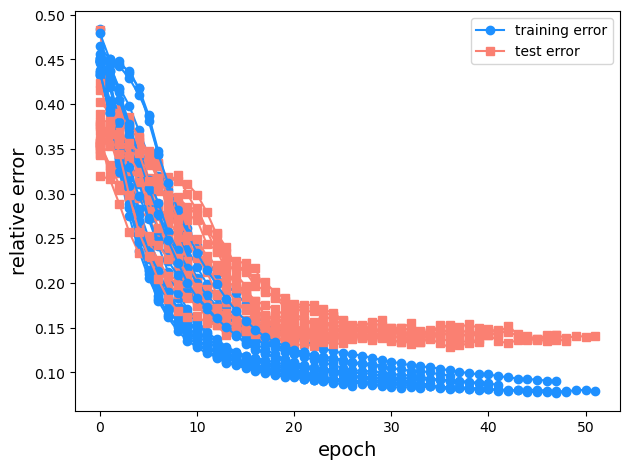

In [16]:
plot_errors(results_das)

### Get training results

In [17]:
# select the surrogate with the lowest test error
epoch_stop = results_das['epoch_stop']
test_errors = np.array(results_das['errors'])[:, :, 1]
test_errors = [error[epoch_stop[idx]] for idx, error in enumerate(test_errors)]
best_idx = np.argmin(test_errors)
das_surrogate = results_das['surrogate'][best_idx]
C_das = results_das['C_das'][best_idx]

# compute the active subspace on the training and test data
W_1 = results_das['projection_matrix'][best_idx]
y_das_train = np.dot(W_1.T, params_train.T).T
y_das_test = np.dot(W_1.T, params_test.T).T

### Recreate the eigenvalue plots

Plot the eigenvalues with confidence intervals. If the replica ensemble contains non-converged networks, this will show up as unreasonably large confidence intervals.

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


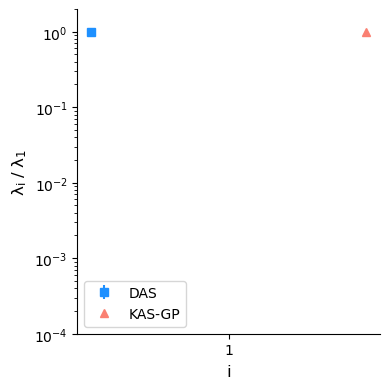

In [18]:
# number of eigenvalues to plot
n_vals = d

# basic analysisclass to compute the confidence intervals
analysis = es.analysis.BaseAnalysis()

# DAS eigenvalues
eigvals_C_das = results_das['eigvals'] 
eigvals_C_das = eigvals_C_das / np.mean(eigvals_C_das, axis=0)[0]
# eigenvalues averaged over the n_rep replica networks
mean_eigval_das = np.mean(eigvals_C_das[:, 0:n_vals], axis=0)
# compute confidence intervals
lower, upper = analysis.get_confidence_intervals(eigvals_C_das[:, 0:n_vals])
y_err_das = np.array([mean_eigval_das - lower, upper - mean_eigval_das])

# Load GP results from file
GP_eigvals = pd.read_csv('./GP_eigvals/scaled_eigen_results_epoxy_%s.csv' % (QoI,))
GP_mean = GP_eigvals['Eigenval_mean'].values
GP_std = GP_eigvals['Eigenval_std'].values

# plot results.
fig = plt.figure(figsize=[4, 4])
ax1 = fig.add_subplot(111, yscale='log', ylim=[1e-4, 2])
ax1.set_ylabel(r'$\lambda_i\;/\;\lambda_1$', fontsize=12)
ax1.set_xlabel(r'$i$', fontsize=12)
offset = 0.1
ax1.errorbar(np.arange(1, n_vals + 1)-offset, mean_eigval_das, 
             yerr = y_err_das, fmt='s', color='dodgerblue', label='DAS')
ax1.errorbar(np.arange(1, n_vals + 1)+offset, GP_mean[0:n_vals], 
             fmt='^', color='salmon', label='KAS-GP')#, yerr = GP_std[0:n_vals])
plt.legend(loc=0)
ax1.set_xticks(np.arange(1, n_vals + 1, 1))
sns.despine(top=True)
plt.tight_layout()

fig.savefig('./images/epoxy_eigvals_d%d.png' % (d,))

### Recreate the active subspace plot

Plot the predictions in a 1D active subspace.

In [19]:
# run the surrogate at a number of random inputs locations drawn from U[-1, 1]
n_mc = 1000
pred_inputs = np.random.rand(n_mc, D) * 2 - 1
das_samples_pred = np.zeros(n_mc)
for i in range(n_mc):
    das_samples_pred[i] = das_surrogate.predict(pred_inputs[i])

In [20]:
# active subspace at prediction inputs x
y_val_das = np.dot(W_1.T, pred_inputs.T).T
idx = np.argsort(y_val_das.flatten())

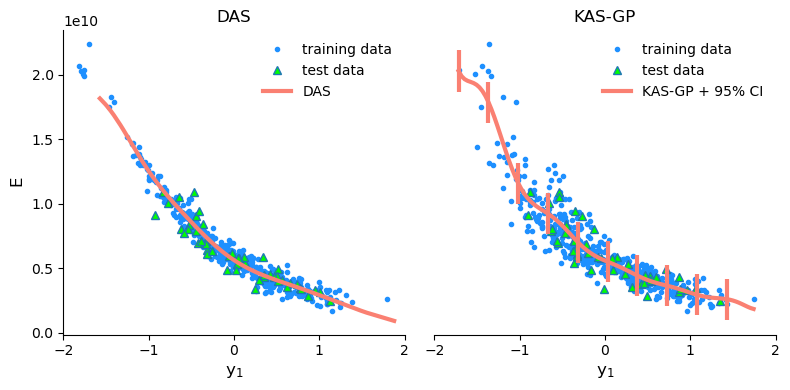

In [21]:
# QoI labels
lbl = {'E11': r'$E$', 'poisson': r'Poisson ratio'}

# plot DAS surrogate
fig = plt.figure(figsize=(8,4))
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 1])

ax = fig.add_subplot(spec[0],  xlim=[-2,2], title='DAS')   
#ax = fig.add_subpl2ot(111, ylim = [0.15, 0.45], xlim= [-2, 2]) # Poisson range
ax.set_xlabel(r'$y_1$', fontsize=12)
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_ylabel(lbl[QoI], fontsize=12)
ax.plot(y_das_train[:,0], samples_train, '.', color='dodgerblue', label='training data') 
ax.plot(y_das_test[:,0], samples_test, '^', markerfacecolor='lime', label='test data') 
ax.plot(y_val_das[idx,0], das_samples_pred[idx], color='salmon', label='DAS', linewidth=3)
leg = ax.legend(loc=0, frameon=False)

ax2 = fig.add_subplot(spec[1], sharex = ax, ylim = ax.get_ylim(), title='KAS-GP') 
ax2.set_xlabel(r'$y_1$', fontsize=12)

# also plot GP surrogate from file
y_mean = das_surrogate.neural_net.y_mean
y_std = das_surrogate.neural_net.y_std
GP_surrogate = np.load('./GP_surrogate/epoxy_%s_results.npy' % (QoI,), allow_pickle=True).item()
ax2.plot(GP_surrogate['reduced_train_params'], samples_train, '.', color='dodgerblue', label='training data')
ax2.plot(GP_surrogate['reduced_test_params'], samples_test, '^', markerfacecolor='lime', label='test data')
ax2.plot(GP_surrogate['active_subspace'], GP_surrogate['prediction_mean'] * y_std + y_mean, color='salmon',
        label='KAS-GP + 95% CI', linewidth=3)
skip=10
ax2.errorbar(GP_surrogate['active_subspace'][0:-1:skip].flatten(), 
             GP_surrogate['prediction_mean'][0:-1:skip].flatten() * y_std + y_mean,
             yerr = GP_surrogate['prediction_CI'][0:-1:skip].flatten() * y_std, color='salmon',
             linewidth=0, elinewidth=3)
leg = ax2.legend(loc=0, frameon=False)

sns.despine(top=True, ax=ax)
sns.despine(top=True, ax=ax2)
sns.despine(left=True, ax=ax2)
ax2.set_yticks([])

plt.tight_layout()
plt.savefig('./images/epoxy_surrogate_d%d_%s.png' % (d, QoI, ))


### Recreate the global-derivative based sensitivity plots

In [22]:
GP_results = pd.read_csv('./GP_SA/sensitivity_indices_epoxy_%s.csv' % (QoI,))

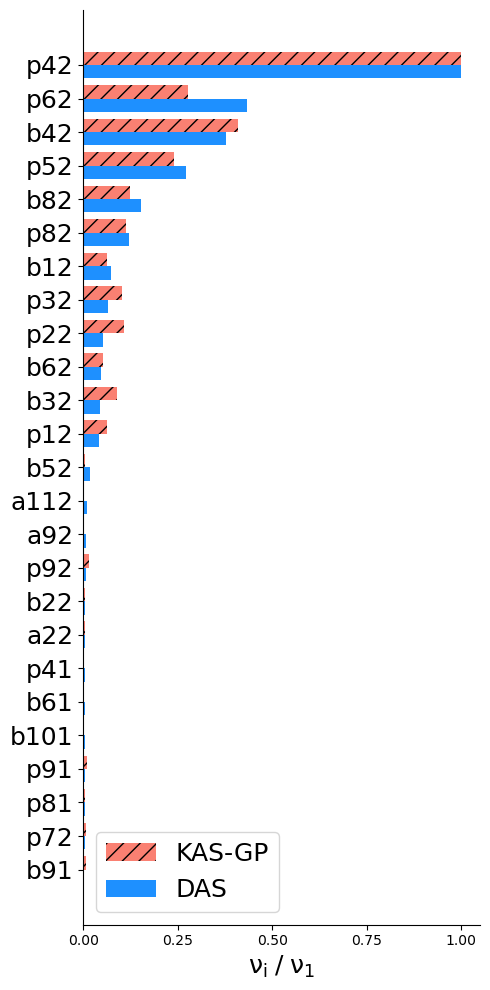

In [23]:
# plot sensitivity indices with CIs
plot_sensitivity(results_das, param_names, bar2 = GP_results)

### Compare epistemic with aleatoric uncertainty

Computing kernel-density estimate
done
Computing kernel-density estimate
done
Computing kernel-density estimate
done


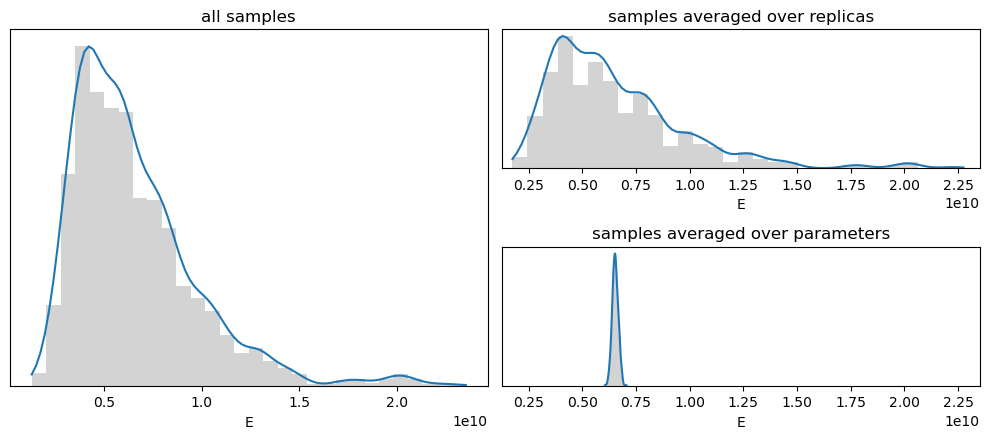

In [24]:
plot_dist(output, lbl[QoI])

### (Non-Gaussian) stats with bootstrapping

In [25]:
n_bootstap = 10 ** 5
n_samples = output.size

mean = np.zeros(n_bootstap)
std = np.zeros(n_bootstap)
skew = np.zeros(n_bootstap)
kurt = np.zeros(n_bootstap)

output = output.flatten() 

for i in tqdm(range(n_bootstap)):
    # resample with replacement
    idx = np.random.randint(0, n_samples, n_samples)
    # recompute moments
    mean[i] = np.mean(output[idx])
    std[i] = np.std(output[idx])
    skew[i] = stats.skew(output[idx])
    kurt[i] = stats.kurtosis(output[idx])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:35<00:00, 464.61it/s]


In [26]:
lower_mean, upper_mean = analysis.get_confidence_intervals(mean.reshape([-1,1]))
lower_std, upper_std = analysis.get_confidence_intervals(std.reshape([-1,1]))
lower_skew, upper_skew = analysis.get_confidence_intervals(skew.reshape([-1,1]))
lower_kurt, upper_kurt = analysis.get_confidence_intervals(kurt.reshape([-1,1]))

In [27]:
print("Mean: %.2e (%.2e/%.2e)" % (np.mean(output), lower_mean, upper_mean))
print("Std dev: %.2e (%.2e/%.2e)" % (np.std(output), lower_std, upper_std))
print("Skew: %.2f (%.3f/%.3f)" % (stats.skew(output), lower_skew, upper_skew))
print("Kurt: %.2f (%.2f/%.2f)" % (stats.kurtosis(output), lower_kurt, upper_kurt))
print("N_samples = %d" % n_samples)

Mean: 6.54e+09 (6.49e+09/6.59e+09)
Std dev: 3.22e+09 (3.16e+09/3.29e+09)
Skew: 1.61 (1.541/1.666)
Kurt: 3.76 (3.46/4.05)
N_samples = 10000
